<a href="https://colab.research.google.com/github/Gaurav-711/UIDAI-Data-Hackathon/blob/main/aadhaar_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression

import os
import warnings
warnings.filterwarnings("ignore")


In [33]:
# GOOGLE DRIVE PATHS
# ------------------------------
DATA_DIR = "/content/drive/MyDrive/aadhaar_hackathon"

ENROLMENT_CSV = f"{DATA_DIR}/enrolment.csv"
DEMO_CSV      = f"{DATA_DIR}/demographic.csv"
BIO_CSV       = f"{DATA_DIR}/biometric.csv"

# OUTPUT PATHS
OUT_DIR   = f"{DATA_DIR}/outputs"
CHART_DIR = f"{OUT_DIR}/charts"

In [34]:
USECOLS = ["date", "state", "district", "pincode", "bio_age_5_17", "bio_age_17_"]

In [35]:
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(CHART_DIR, exist_ok=True)
print("✅ Output folders ready:", OUT_DIR)


✅ Output folders ready: /content/drive/MyDrive/aadhaar_hackathon/outputs


In [38]:
def detect_age_columns(file_path):
    """
    Detect actual age columns in your CSV file automatically.
    Works even if there are spaces / different names.
    """
    cols = pd.read_csv(file_path, nrows=1).columns.tolist()
    cols_clean = [c.strip() for c in cols]

    # Find 5-17 column
    col_5_17 = None
    col_17_plus = None

    for c in cols_clean:
        cl = c.lower()
        if ("5" in cl and "17" in cl):
            col_5_17 = c
        if ("17" in cl and col_17_plus is None and "5" not in cl):
            col_17_plus = c

    # fallback: take last 2 columns after pincode
    if col_5_17 is None or col_17_plus is None:
        # find index of pincode
        if "pincode" in [x.lower() for x in cols_clean]:
            pidx = [x.lower() for x in cols_clean].index("pincode")
            remaining = cols_clean[pidx+1:]
            if len(remaining) >= 2:
                col_5_17 = col_5_17 or remaining[0]
                col_17_plus = col_17_plus or remaining[1]

    return cols_clean, col_5_17, col_17_plus


# Test detection once
cols, age_5_17_col, age_17plus_col = detect_age_columns(ENROLMENT_CSV)
print("✅ Columns found:", cols)
print("✅ Detected 5-17 column:", age_5_17_col)
print("✅ Detected 17+ column:", age_17plus_col)


✅ Columns found: ['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17', 'age_18_greater']
✅ Detected 5-17 column: age_5_17
✅ Detected 17+ column: age_5_17


In [41]:
def ensure_dirs():
    import os
    os.makedirs(OUT_DIR, exist_ok=True)
    os.makedirs(CHART_DIR, exist_ok=True)

def optimize_types(df):
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    df["state"] = df["state"].astype("category")
    df["district"] = df["district"].astype("category")
    df["pincode"] = pd.to_numeric(df["pincode"], errors="coerce").astype("Int32")

    df["age_0_5"] = 0  # not available in your dataset
    df["age_5_17"] = pd.to_numeric(df["age_5_17"], errors="coerce").fillna(0).astype("int32")
    df["age_18_greater"] = pd.to_numeric(df["age_18_greater"], errors="coerce").fillna(0).astype("int32")

    df["total"] = df["age_0_5"] + df["age_5_17"] + df["age_18_greater"]
    return df

def smart_sample_csv(file_path, record_type, file_usecols, file_rename_map, sample_target=SAMPLE_ROWS_PER_FILE):
    """
    Reads in chunks, keeps top states, samples limited rows.
    """
    print(f"\nfff Scanning {record_type} for top states...")

    # -------- Pass 1: compute state totals
    state_totals = {}

    for chunk in pd.read_csv(file_path, usecols=file_usecols, chunksize=CHUNK_SIZE):
        chunk = chunk.rename(columns=file_rename_map)
        chunk = optimize_types(chunk)
        st_sum = chunk.groupby("state")["total"].sum()

        for st, val in st_sum.items():
            state_totals[st] = state_totals.get(st, 0) + val

    top_states = sorted(state_totals, key=state_totals.get, reverse=True)[:TOP_STATES]
    top_states = [str(x) for x in top_states]
    print(f"✅ Selected top {TOP_STATES} states for {record_type}")

    # -------- Pass 2: sample rows
    print(f"fff Sampling {sample_target} rows from {record_type}...")
    sampled = []
    collected = 0

    for chunk in pd.read_csv(file_path, usecols=file_usecols, chunksize=CHUNK_SIZE):
        chunk = chunk.rename(columns=file_rename_map)
        chunk = optimize_types(chunk)

        chunk["state"] = chunk["state"].astype(str)
        chunk = chunk[chunk["state"].isin(top_states)]
        if chunk.empty:
            continue

        remaining = sample_target - collected
        if remaining <= 0:
            break

        take_n = min(len(chunk), max(1000, int(0.2 * len(chunk))))
        take_n = min(take_n, remaining)

        samp = chunk.sample(n=take_n, random_state=RANDOM_SEED)
        samp["record_type"] = record_type
        sampled.append(samp)

        collected += take_n
        print(f"   collected {collected}/{sample_target}")

    df = pd.concat(sampled, ignore_index=True)

    # Reduce pincodes
    top_pins = df["pincode"].value_counts().head(MAX_PINCODES).index
    df = df[df["pincode"].isin(top_pins)].copy()

    df["total"] = df["age_0_5"] + df["age_5_17"] + df["age_18_greater"]
    return df


fff Scanning enrolment for top states...
✅ Selected top 20 states for enrolment
fff Sampling 120000 rows from enrolment...
   collected 9375/120000
   collected 18777/120000
   collected 28198/120000
   collected 37591/120000
   collected 47005/120000
   collected 56387/120000
   collected 65785/120000
   collected 75172/120000
   collected 84605/120000
   collected 94009/120000

fff Scanning demographic_update for top states...
✅ Selected top 20 states for demographic_update
fff Sampling 120000 rows from demographic_update...
   collected 9415/120000
   collected 18825/120000
   collected 28236/120000
   collected 37703/120000
   collected 47190/120000
   collected 56664/120000
   collected 66108/120000
   collected 75558/120000
   collected 84948/120000
   collected 94269/120000

fff Scanning biometric_update for top states...
✅ Selected top 20 states for biometric_update
fff Sampling 120000 rows from biometric_update...
   collected 9378/120000
   collected 18812/

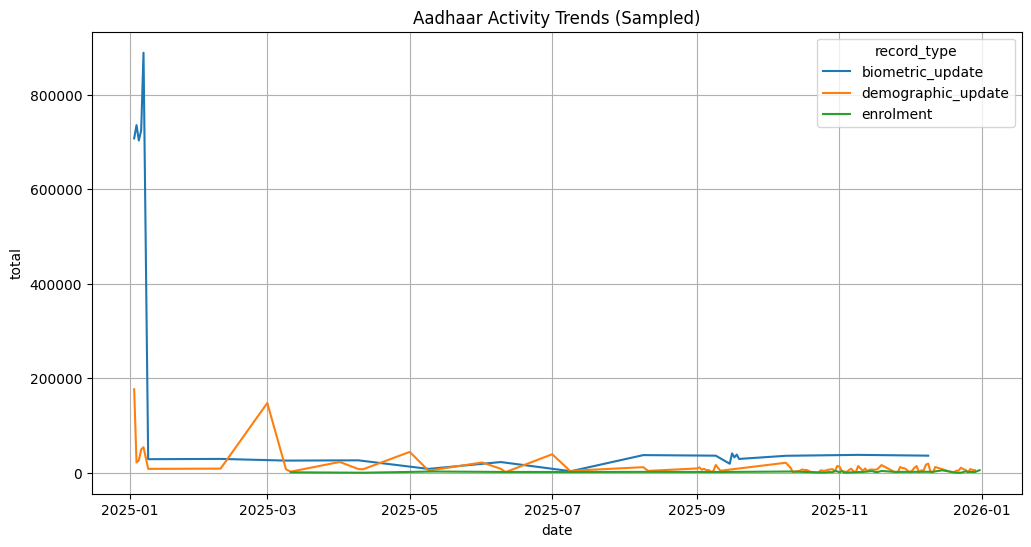

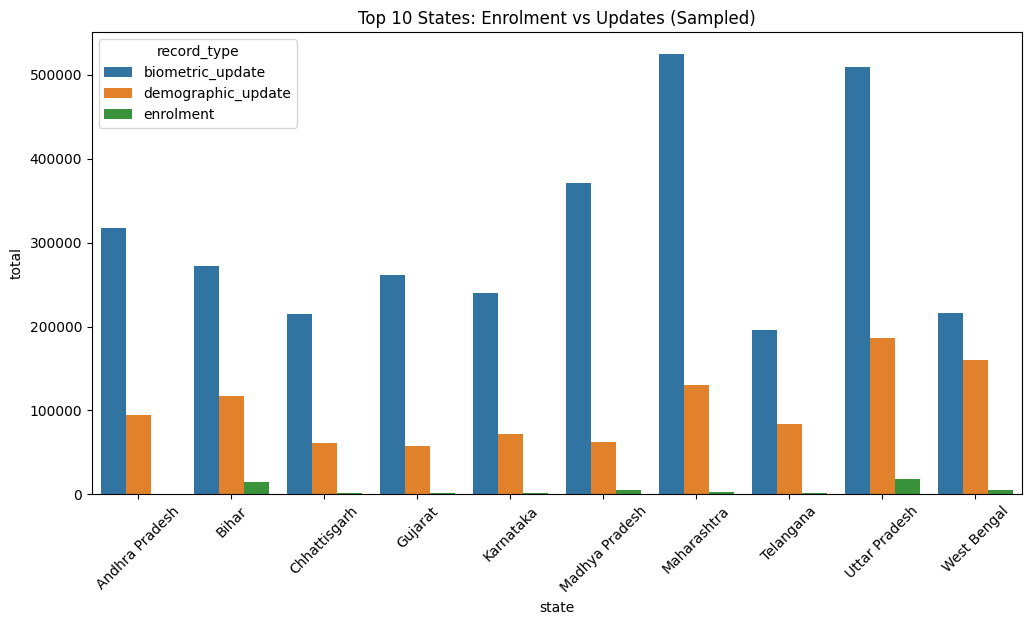

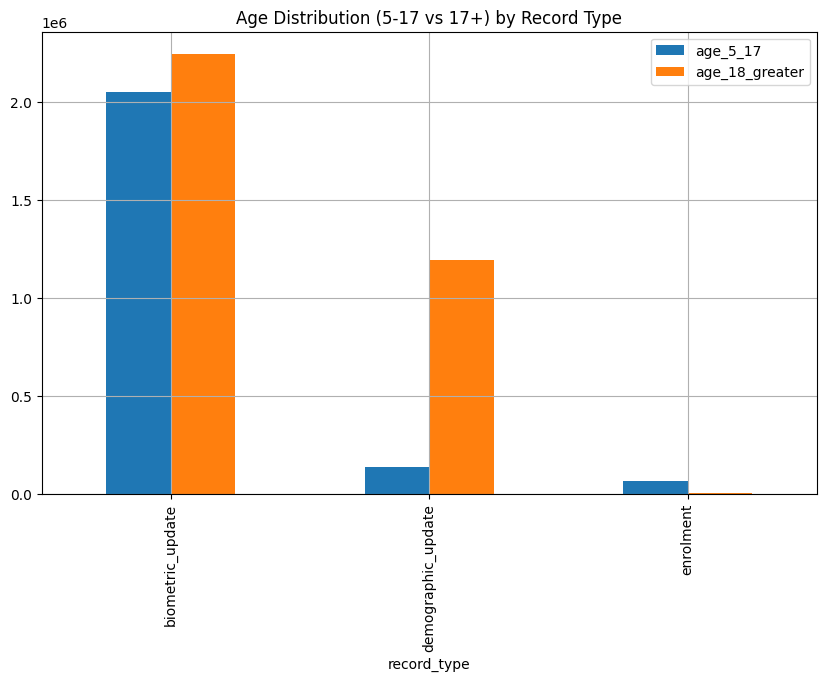

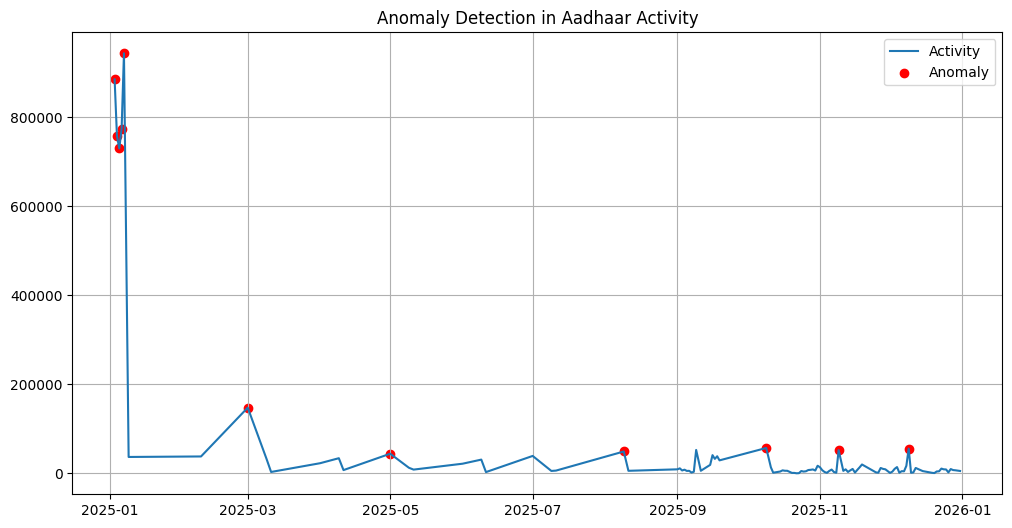

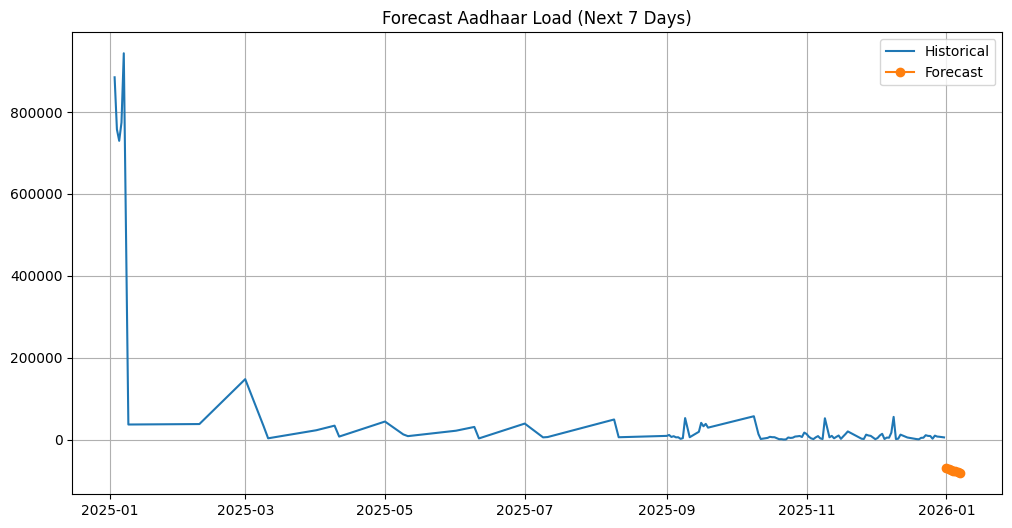


✅ Completed! All outputs saved in: /content/drive/MyDrive/aadhaar_hackathon/outputs


,date,state,district,pincode,age_5_17,age_18_greater,age_0_5,total,record_type
0,2025-10-29,Assam,Udalguri,784116,1,0,0,1,enrolment
1,2025-10-28,Karnataka,Bangalore Rural,562110,0,1,0,1,enrolment
2,2025-10-27,Uttar Pradesh,Allahabad,212305,1,0,0,1,enrolment
3,2025-10-28,Karnataka,Vijayapura,586214,1,0,0,1,enrolment
4,2025-10-28,Bihar,Muzaffarpur,843128,1,0,0,1,enrolment


In [42]:
OUT_DIR   = f"{DATA_DIR}/outputs"
CHART_DIR = f"{OUT_DIR}/charts"

# MAIN PIPELINE
# -----------------------------
def run_project():
    ensure_dirs()

    # Define specific usecols and rename maps for each file type
    # Corrected for enrolment.csv based on actual columns (age_5_17, age_18_greater)
    enrolment_usecols = ["date", "state", "district", "pincode", "age_5_17", "age_18_greater"]
    enrolment_rename_map = {"age_5_17": "age_5_17", "age_18_greater": "age_18_greater"}

    demographic_usecols = ["date", "state", "district", "pincode", "demo_age_5_17", "demo_age_17_"]
    demographic_rename_map = {"demo_age_5_17": "age_5_17", "demo_age_17_": "age_18_greater"}

    biometric_usecols = ["date", "state", "district", "pincode", "bio_age_5_17", "bio_age_17_"]
    biometric_rename_map = {"bio_age_5_17": "age_5_17", "bio_age_17_": "age_18_greater"}

    enrol = smart_sample_csv(ENROLMENT_CSV, "enrolment", enrolment_usecols, enrolment_rename_map)
    demo  = smart_sample_csv(DEMO_CSV, "demographic_update", demographic_usecols, demographic_rename_map)
    bio   = smart_sample_csv(BIO_CSV, "biometric_update", biometric_usecols, biometric_rename_map)

    df = pd.concat([enrol, demo, bio], ignore_index=True)

    # Save combined sampled dataset
    df.to_csv(f"{OUT_DIR}/combined_sampled_uidai.csv", index=False)
    print("\n✅ Combined sampled dataset saved to Drive.")

    # -----------------------------
    # 1) Trend analysis
    # -----------------------------
    monthly = df.groupby(["date", "record_type"])["total"].sum().reset_index()
    monthly = monthly.sort_values("date")

    plt.figure(figsize=(12,6))
    sns.lineplot(data=monthly, x="date", y="total", hue="record_type")
    plt.title("Aadhaar Activity Trends (Sampled)")
    plt.grid(True)
    plt.savefig(f"{CHART_DIR}/monthly_trend_by_type.png", dpi=200, bbox_inches="tight")
    plt.show()

    # -----------------------------
    # 2) Top states activity
    # -----------------------------
    top_states = df.groupby("state")["total"].sum().sort_values(ascending=False).head(10).index
    state_total = df[df["state"].isin(top_states)].groupby(["state","record_type"])["total"].sum().reset_index()

    plt.figure(figsize=(12,6))
    sns.barplot(data=state_total, x="state", y="total", hue="record_type")
    plt.title("Top 10 States: Enrolment vs Updates (Sampled)")
    plt.xticks(rotation=45)
    plt.savefig(f"{CHART_DIR}/top_states_activity.png", dpi=200, bbox_inches="tight")
    plt.show()

    # -----------------------------
    # 3) Age distribution
    # -----------------------------
    age_summary = df.groupby("record_type")[["age_5_17","age_18_greater"]].sum()
    age_summary.plot(kind="bar", figsize=(10,6))
    plt.title("Age Distribution (5-17 vs 17+) by Record Type")
    plt.grid(True)
    plt.savefig(f"{CHART_DIR}/age_distribution.png", dpi=200, bbox_inches="tight")
    plt.show()

    # -----------------------------
    # 4) Anomaly detection (global)
    # -----------------------------
    total_by_date = df.groupby("date")["total"].sum().reset_index()
    total_by_date = total_by_date.sort_values("date")

    if len(total_by_date) >= 10:
        scaler = StandardScaler()
        total_by_date["scaled"] = scaler.fit_transform(total_by_date[["total"]])

        iso = IsolationForest(contamination=0.1, random_state=RANDOM_SEED)
        total_by_date["anomaly"] = iso.fit_predict(total_by_date[["scaled"]])
        total_by_date["anomaly"] = total_by_date["anomaly"].map({1:0, -1:1})

        plt.figure(figsize=(12,6))
        plt.plot(total_by_date["date"], total_by_date["total"], label="Activity")
        plt.scatter(
            total_by_date[total_by_date["anomaly"]==1]["date"],
            total_by_date[total_by_date["anomaly"]==1]["total"],
            color="red", label="Anomaly"
        )
        plt.title("Anomaly Detection in Aadhaar Activity")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{CHART_DIR}/anomaly_detection.png", dpi=200, bbox_inches="tight")
        plt.show()

    # -----------------------------
    # 5) Forecasting (only if enough dates)
    # -----------------------------
    if len(total_by_date) >= 15:
        total_by_date["t"] = np.arange(len(total_by_date))
        X = total_by_date[["t"]]
        y = total_by_date["total"]

        reg = LinearRegression()
        reg.fit(X, y)

        FUTURE_DAYS = 7
        future_t = np.arange(len(total_by_date), len(total_by_date)+FUTURE_DAYS).reshape(-1,1)
        preds = reg.predict(future_t)

        future_dates = pd.date_range(
            start=total_by_date["date"].max(),
            periods=FUTURE_DAYS+1,
            freq="D"
        )[1:]

        plt.figure(figsize=(12,6))
        plt.plot(total_by_date["date"], y, label="Historical")
        plt.plot(future_dates, preds, marker="o", label="Forecast")
        plt.title("Forecast Aadhaar Load (Next 7 Days)")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{CHART_DIR}/forecast_next_7_days.png", dpi=200, bbox_inches="tight")
        plt.show()

    # -----------------------------
    # Summary insights file
    # -----------------------------
    summary = pd.DataFrame({
        "Metric": [
            "Total sampled rows",
            "Available date range",
            "Most active state",
            "Most active record type"
        ],
        "Value": [
            len(df),
            f"{df['date'].min().date()} to {df['date'].max().date()}",
            df.groupby("state")["total"].sum().sort_values(ascending=False).index[0],
            df.groupby("record_type")["total"].sum().sort_values(ascending=False).index[0]
        ]
    })

    summary.to_csv(f"{OUT_DIR}/summary_insights.csv", index=False)
    print("\n✅ Completed! All outputs saved in:", OUT_DIR)

    return df

# RUN
combined_df = run_project()
combined_df.head()

In [43]:
import pandas as pd

combined_path = "/content/drive/MyDrive/aadhaar_hackathon/outputs/combined_sampled_uidai.csv"
df = pd.read_csv(combined_path)

df.head()


,date,state,district,pincode,age_5_17,age_18_greater,age_0_5,total,record_type
0,2025-10-29,Assam,Udalguri,784116,1,0,0,1,enrolment
1,2025-10-28,Karnataka,Bangalore Rural,562110,0,1,0,1,enrolment
2,2025-10-27,Uttar Pradesh,Allahabad,212305,1,0,0,1,enrolment
3,2025-10-28,Karnataka,Vijayapura,586214,1,0,0,1,enrolment
4,2025-10-28,Bihar,Muzaffarpur,843128,1,0,0,1,enrolment


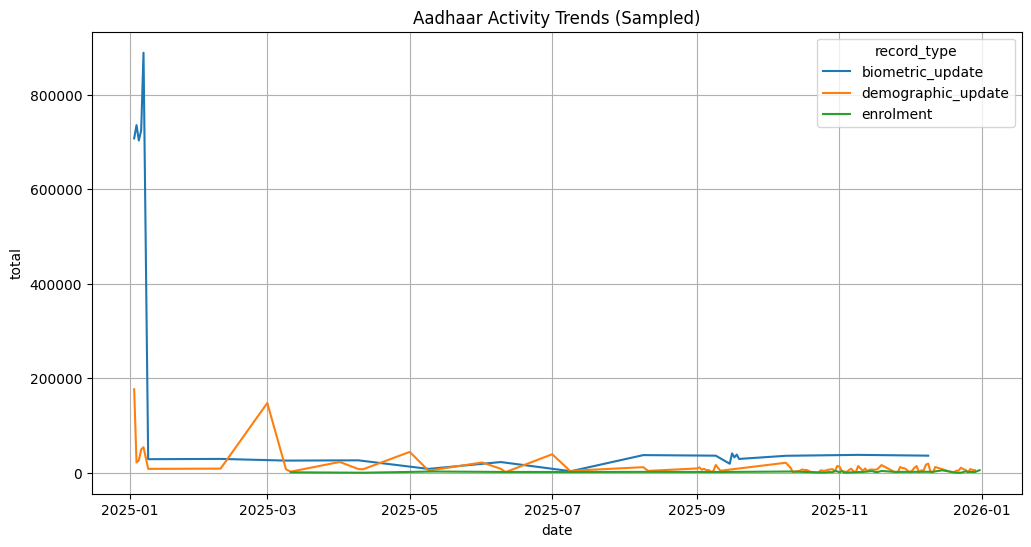

In [44]:
#trends and charts
monthly = combined_df.groupby(["date", "record_type"])["total"].sum().reset_index().sort_values("date")

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly, x="date", y="total", hue="record_type")
plt.title("Aadhaar Activity Trends (Sampled)")
plt.grid(True)
plt.savefig(f"{CHART_DIR}/monthly_trend_by_type.png", dpi=200, bbox_inches="tight")
plt.show()


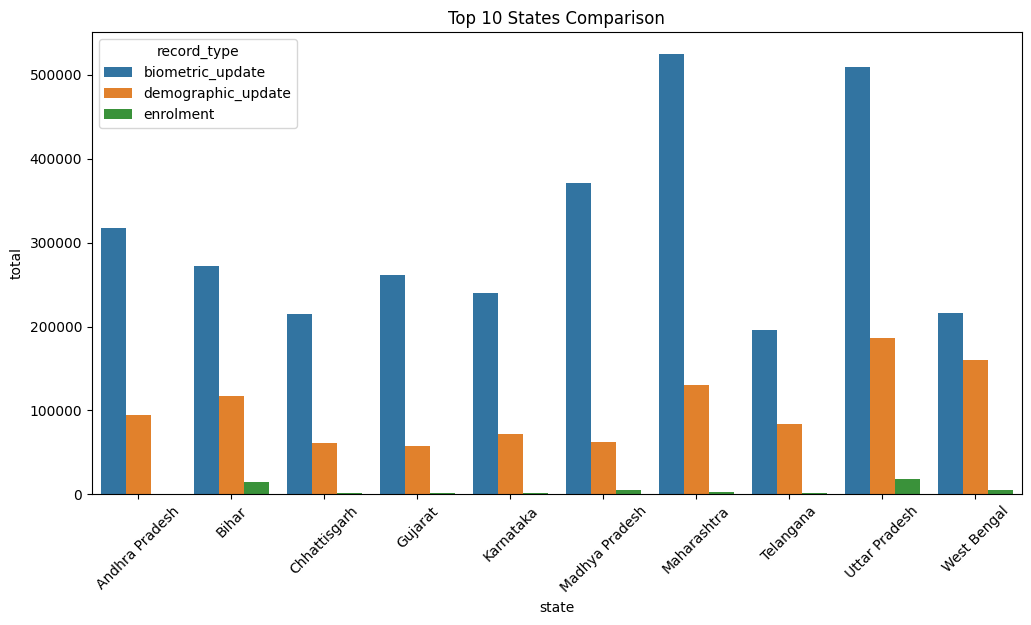

In [45]:
top_states = combined_df.groupby("state")["total"].sum().sort_values(ascending=False).head(10).index
state_total = combined_df[combined_df["state"].isin(top_states)].groupby(["state","record_type"])["total"].sum().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=state_total, x="state", y="total", hue="record_type")
plt.title("Top 10 States Comparison")
plt.xticks(rotation=45)
plt.savefig(f"{CHART_DIR}/top_states_activity.png", dpi=200, bbox_inches="tight")
plt.show()


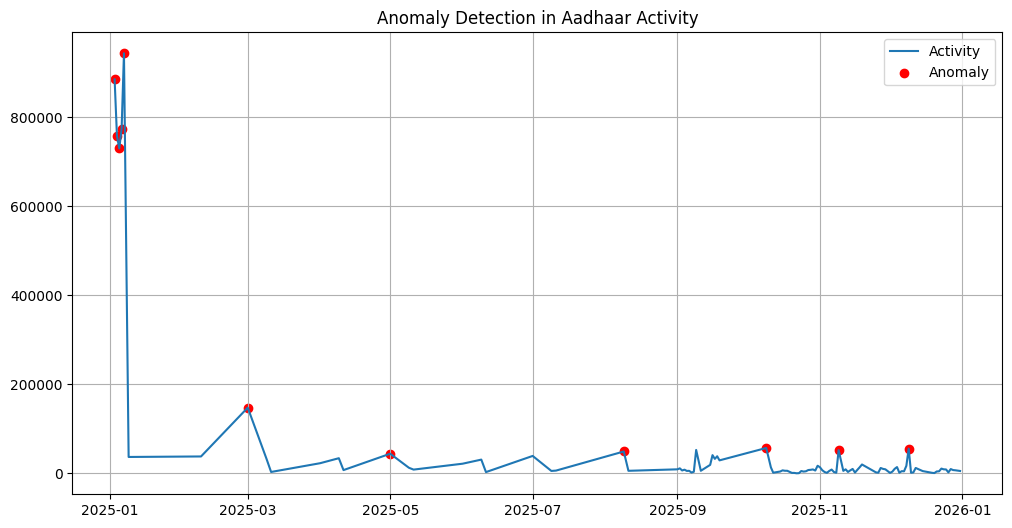

In [46]:
total_by_date = combined_df.groupby("date")["total"].sum().reset_index().sort_values("date")

if len(total_by_date) >= 10:
    scaler = StandardScaler()
    total_by_date["scaled"] = scaler.fit_transform(total_by_date[["total"]])

    iso = IsolationForest(contamination=0.1, random_state=RANDOM_SEED)
    total_by_date["anomaly"] = iso.fit_predict(total_by_date[["scaled"]])
    total_by_date["anomaly"] = total_by_date["anomaly"].map({1:0, -1:1})

    plt.figure(figsize=(12,6))
    plt.plot(total_by_date["date"], total_by_date["total"], label="Activity")
    plt.scatter(total_by_date[total_by_date["anomaly"]==1]["date"],
                total_by_date[total_by_date["anomaly"]==1]["total"],
                color="red", label="Anomaly")
    plt.title("Anomaly Detection in Aadhaar Activity")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{CHART_DIR}/anomaly_detection.png", dpi=200, bbox_inches="tight")
    plt.show()
else:
    print("⚠️ Not enough unique dates for anomaly detection.")


In [47]:
summary = pd.DataFrame({
    "Metric": [
        "Total sampled rows",
        "Available date range",
        "Most active state",
        "Most active record type"
    ],
    "Value": [
        len(combined_df),
        f"{combined_df['date'].min().date()} to {combined_df['date'].max().date()}",
        combined_df.groupby("state")["total"].sum().sort_values(ascending=False).index[0],
        combined_df.groupby("record_type")["total"].sum().sort_values(ascending=False).index[0]
    ]
})

summary_path = f"{OUT_DIR}/summary_insights.csv"
summary.to_csv(summary_path, index=False)
print("✅ Summary saved:", summary_path)

summary


✅ Summary saved: /content/drive/MyDrive/aadhaar_hackathon/outputs/summary_insights.csv


,Metric,Value
0,Total sampled rows,139834
1,Available date range,2025-01-03 to 2025-12-31
2,Most active state,Uttar Pradesh
3,Most active record type,biometric_update


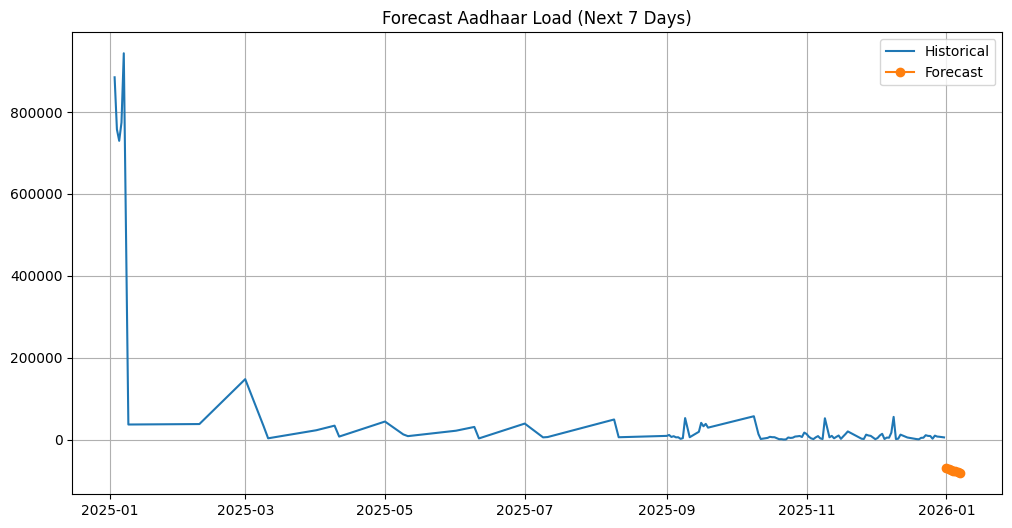

In [48]:
#forecasting
if len(total_by_date) >= 15:
    total_by_date["t"] = np.arange(len(total_by_date))

    X = total_by_date[["t"]]
    y = total_by_date["total"]

    reg = LinearRegression()
    reg.fit(X, y)

    FUTURE_DAYS = 7
    future_t = np.arange(len(total_by_date), len(total_by_date)+FUTURE_DAYS).reshape(-1,1)
    preds = reg.predict(future_t)

    future_dates = pd.date_range(
        start=total_by_date["date"].max(),
        periods=FUTURE_DAYS+1,
        freq="D"
    )[1:]

    plt.figure(figsize=(12,6))
    plt.plot(total_by_date["date"], y, label="Historical")
    plt.plot(future_dates, preds, marker="o", label="Forecast")
    plt.title("Forecast Aadhaar Load (Next 7 Days)")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{CHART_DIR}/forecast_next_7_days.png", dpi=200, bbox_inches="tight")
    plt.show()
else:
    print("⚠️ Not enough unique dates for forecasting.")


In [49]:
summary = pd.DataFrame({
    "Metric": [
        "Total sampled rows",
        "Available date range",
        "Most active state",
        "Most active record type"
    ],
    "Value": [
        len(combined_df),
        f"{combined_df['date'].min().date()} to {combined_df['date'].max().date()}",
        combined_df.groupby("state")["total"].sum().sort_values(ascending=False).index[0],
        combined_df.groupby("record_type")["total"].sum().sort_values(ascending=False).index[0]
    ]
})

summary_path = f"{OUT_DIR}/summary_insights.csv"
summary.to_csv(summary_path, index=False)

print("✅ Summary insights saved to:", summary_path)
summary


✅ Summary insights saved to: /content/drive/MyDrive/aadhaar_hackathon/outputs/summary_insights.csv


,Metric,Value
0,Total sampled rows,139834
1,Available date range,2025-01-03 to 2025-12-31
2,Most active state,Uttar Pradesh
3,Most active record type,biometric_update


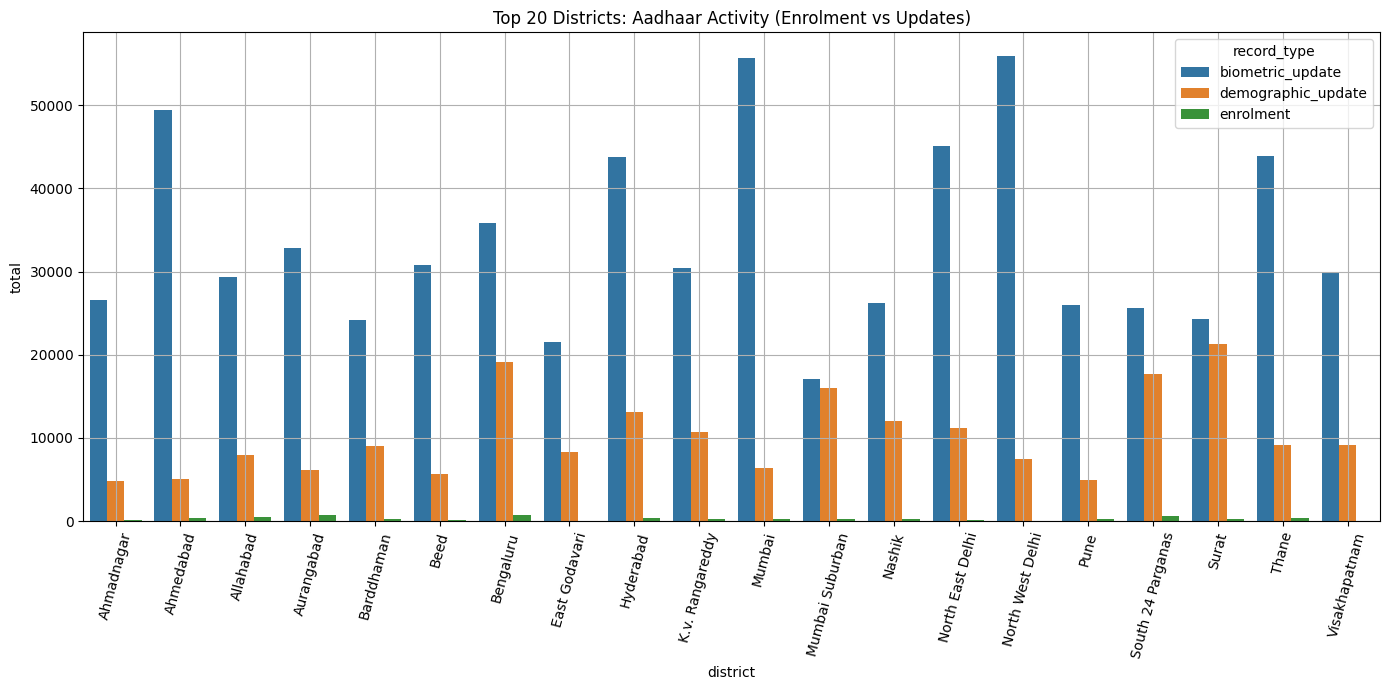

In [50]:
top_districts = (df.groupby("district")["total"]
                 .sum()
                 .sort_values(ascending=False)
                 .head(20)
                 .index)

district_summary = (df[df["district"].isin(top_districts)]
                    .groupby(["district", "record_type"])["total"]
                    .sum()
                    .reset_index())

plt.figure(figsize=(14,7))
sns.barplot(data=district_summary, x="district", y="total", hue="record_type")
plt.title("Top 20 Districts: Aadhaar Activity (Enrolment vs Updates)")
plt.xticks(rotation=75)
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/aadhaar_hackathon/outputs/charts/top_20_districts.png", dpi=200)
plt.show()


In [51]:
top_pincode_table = (df.groupby("pincode")["total"]
                     .sum()
                     .sort_values(ascending=False)
                     .head(25)
                     .reset_index())

top_pincode_table.to_csv("/content/drive/MyDrive/aadhaar_hackathon/outputs/top_25_pincodes.csv", index=False)
top_pincode_table


,pincode,total
0,110094,33510
1,110086,29901
2,110093,17994
3,451551,16676
4,385535,16538
5,110053,16267
6,451001,15301
7,110043,14771
8,486661,14541
9,394210,14484


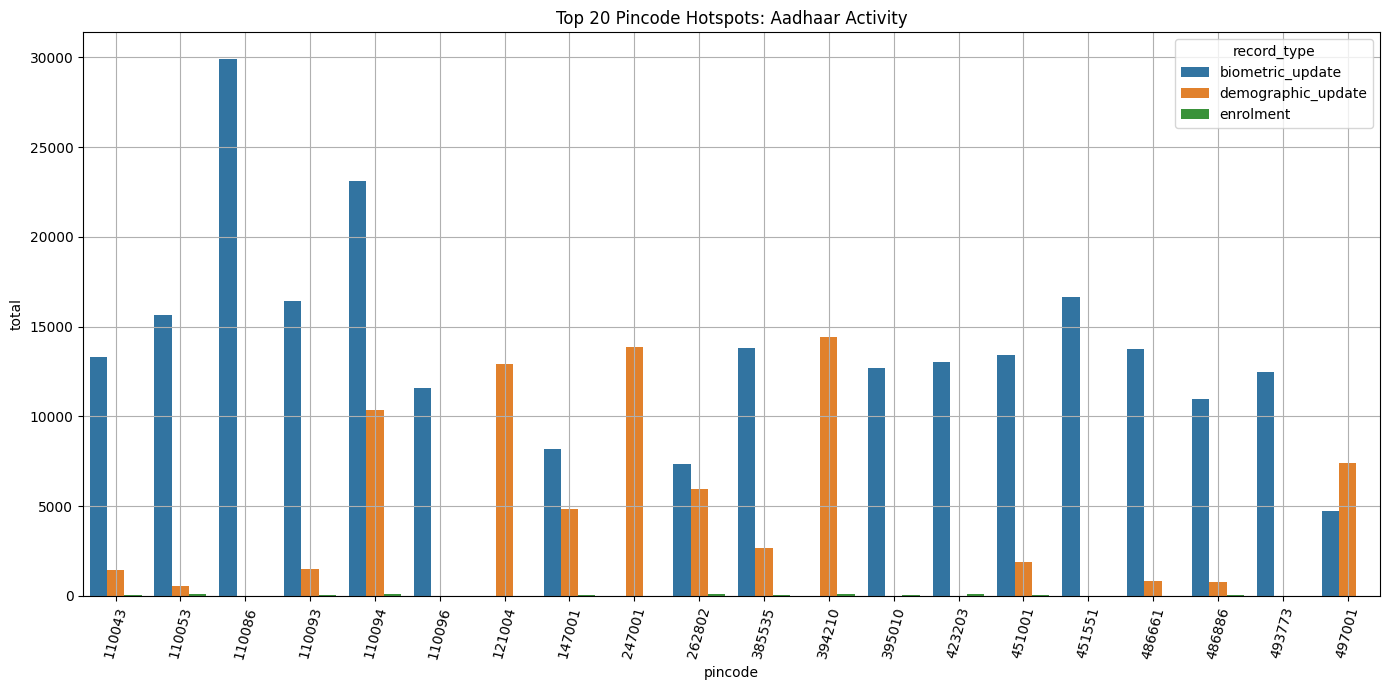

In [52]:
top_pins = top_pincode_table.head(20)["pincode"]

pin_summary = (df[df["pincode"].isin(top_pins)]
               .groupby(["pincode", "record_type"])["total"]
               .sum()
               .reset_index())

plt.figure(figsize=(14,7))
sns.barplot(data=pin_summary, x="pincode", y="total", hue="record_type")
plt.title("Top 20 Pincode Hotspots: Aadhaar Activity")
plt.xticks(rotation=75)
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/aadhaar_hackathon/outputs/charts/top_20_pincodes.png", dpi=200)
plt.show()


In [53]:
#UpdatePressure = (Demographic + Biometric) / Enrolment
state_type = df.groupby(["state", "record_type"])["total"].sum().unstack(fill_value=0)

# safe division
state_type["update_pressure_ratio"] = (
    (state_type.get("demographic_update", 0) + state_type.get("biometric_update", 0)) /
    (state_type.get("enrolment", 1))
)

update_pressure = state_type["update_pressure_ratio"].sort_values(ascending=False).head(15)
update_pressure.to_csv("/content/drive/MyDrive/aadhaar_hackathon/outputs/top_15_update_pressure_states.csv")

update_pressure


,update_pressure_ratio
state,
Uttarakhand,inf
Haryana,inf
Andhra Pradesh,535.843953
Delhi,259.807990
Punjab,249.155598
Maharashtra,218.853756
Odisha,215.332903
Chhattisgarh,203.343382
Telangana,180.362347


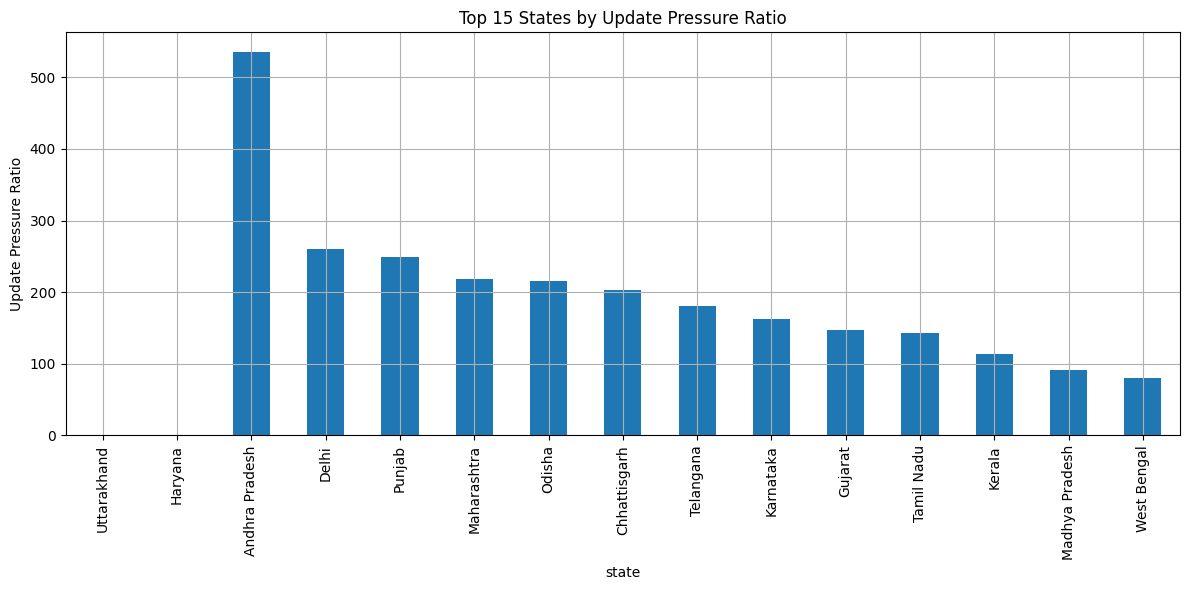

In [54]:
plt.figure(figsize=(12,6))
update_pressure.plot(kind="bar")
plt.title("Top 15 States by Update Pressure Ratio")
plt.ylabel("Update Pressure Ratio")
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/aadhaar_hackathon/outputs/charts/update_pressure_states.png", dpi=200)
plt.show()


In [55]:
#Adult share % per state
state_age = df.groupby("state")[["age_5_17", "age_18_greater"]].sum()
state_age["adult_share_%"] = (state_age["age_18_greater"] / (state_age["age_5_17"] + state_age["age_18_greater"])) * 100

adult_share = state_age["adult_share_%"].sort_values(ascending=False).head(15)
adult_share.to_csv("/content/drive/MyDrive/aadhaar_hackathon/outputs/top_15_adult_share_states.csv")

adult_share


,adult_share_%
state,
Uttarakhand,88.644452
Chhattisgarh,81.183993
West Bengal,72.140090
Punjab,69.401966
Haryana,68.039061
Maharashtra,67.376098
Tamil Nadu,63.894480
Bihar,63.182325
Delhi,62.974895


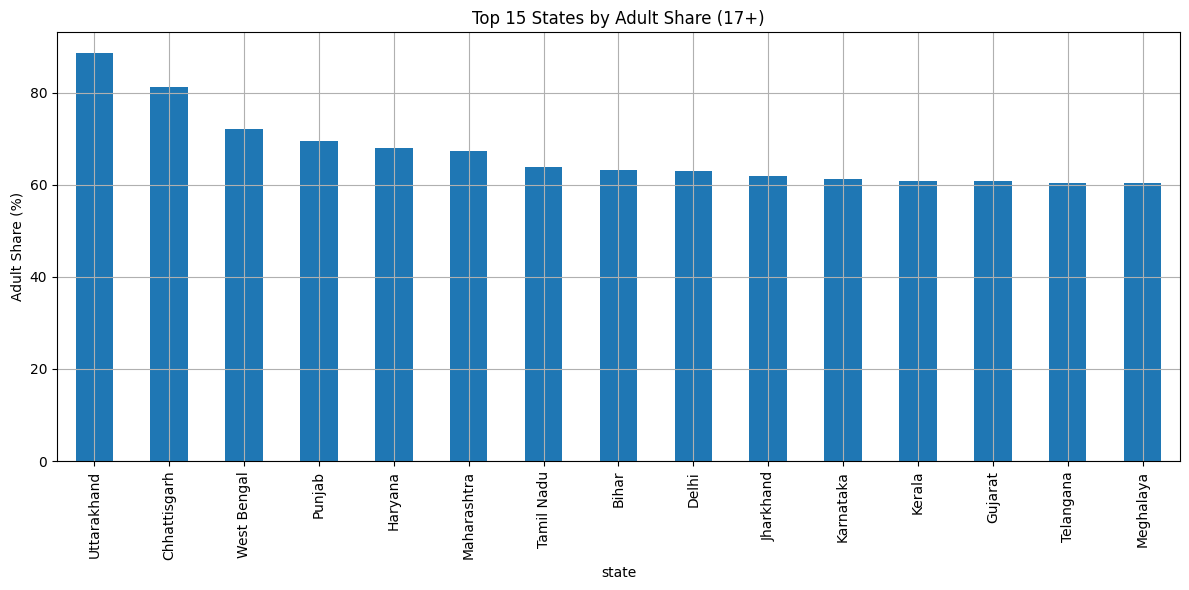

In [56]:
plt.figure(figsize=(12,6))
adult_share.plot(kind="bar")
plt.title("Top 15 States by Adult Share (17+)")
plt.ylabel("Adult Share (%)")
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/aadhaar_hackathon/outputs/charts/adult_share_states.png", dpi=200)
plt.show()


In [58]:
#Anomaly dates + what caused it
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

daily_total = df.groupby("date")["total"].sum().reset_index().sort_values("date")

scaler = StandardScaler()
daily_total["scaled"] = scaler.fit_transform(daily_total[["total"]])

iso = IsolationForest(contamination=0.1, random_state=42)
daily_total["anomaly"] = iso.fit_predict(daily_total[["scaled"]])
daily_total["anomaly"] = daily_total["anomaly"].map({1:0, -1:1})

anomaly_dates = daily_total[daily_total["anomaly"] == 1]["date"].tolist()
print("Anomaly dates:", anomaly_dates)


Anomaly dates: ['2025-01-03', '2025-01-04', '2025-01-05', '2025-01-06', '2025-01-07', '2025-03-01', '2025-05-01', '2025-08-09', '2025-10-09', '2025-11-09', '2025-12-09']
